# SIXT33N Phase 2: Controls | Closed-Loop Control
## EE16B: Designing Information Devices and Systems II, Fall 2019

## Table of Contents

* [Introduction](#intro)
* [Part 1: Jolt Calculation](#part1)
* [Part 2.1: Closed Loop Design](#part21)
* [Part 2.2: Closed Loop Simulation and k-Value Selection](#part22)
* [Part 2.3: Closed Loop Implementation](#part23)
* [Part 2.4: k-Value Tuning](#part24)
* [Part 2.5: Steady-State Error Correction](#part25)
* [Part 3: Open Loop Comparison](#part3) 


<a id='part1'></a>

## 1 Jolt Calculation

### <a href="https://drive.google.com/file/d/1aOfVURyRcfJG4s2wVjpLsnJn8tfcKcM4/view?usp=sharing\">Before you proceed, read Parts 1-3 of the note.</a>

We find the jolts below by calculating the inputs that result in the minimum of the maximum velocities of both wheels. 

- **Make sure your `data_coarse.txt` file from System ID is in the same directory as the iPython notebook.**
- Run the code below to find your initial jolt values.
- Your initial jolt values are correct if they are the input values that correspond to the points where the blue and yellow lines intersect the green line respectively.

In [3]:
import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

int left_jolt = 165;
int right_jolt = 200;


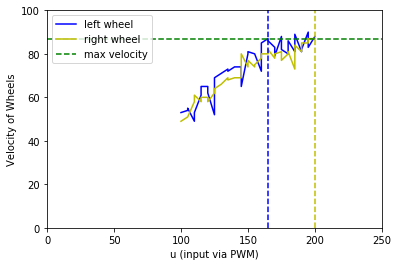

In [4]:
left_jolt, right_jolt = utils.find_jolt()
print('int left_jolt = {};\nint right_jolt = {};'.format(left_jolt, right_jolt))

<a id='part21'></a>
## Closed Loop Design

We can build a closed loop controller that uses feedback to ensure that both wheels drive at the same velocity. The controller has 2 inputs, namely the desired velocity and the difference between the wheel distances $\delta[k] = d_L[k] - d_R[k]$.

### 1. Please make sure you have read the <a href="https://drive.google.com/file/d/1aOfVURyRcfJG4s2wVjpLsnJn8tfcKcM4/view?usp=sharing\">the note </a> before you begin. You may also find it helpful to read <a href="https://inst.eecs.berkeley.edu/~ee16b/fa17/proj/controls-primer.pdf">this PDF</a> for the derivation of the closed-loop system and its eigenvalue.

<span style='color:red'>**2. Using the information above, draw a block diagram of both wheels' controllers.**</span> Show this diagram to your GSI before moving on. Keep this somewhere, as you will use it in your report.

<span style='color:red'>**3. Now derive the closed loop update equation for the differences $\delta[k]$ corresponding to your controller.**</span> Keep this somewhere, as you will use it in your report.

Now that we've derived the model, we can begin implementing it. Fill in the two functions below.

In [5]:
# YOUR PARAMETERS HERE
theta_left = 0.3975;
theta_right = 0.3609;
beta_left = -16.85;
beta_right = -20.08;
v_star = 78.8;

simulator = utils.Simulator(theta_left, theta_right, beta_left, beta_right)

In [13]:
# DESIGN YOUR CLOSED-LOOP CONTROL HERE
def drive_straight_left_cl(v_star, delta):
    """Returns the closed loop input 'u' for the left wheel"""
    # YOUR CODE HERE
    return (v_star + beta_left - k_left*delta)/ theta_left

def drive_straight_right_cl(v_star, delta):
    """Returns the closed loop input 'u' for the right wheel"""
    # YOUR CODE HERE
    return (v_star + beta_right + k_right*delta)/ theta_right

<a id='part22'></a>
## Closed Loop Simulation and K-Value Selection

Next we need to choose values for the control gains so that the $\delta[k]$ update equation is stable. There should be a range of parameter values that make it stable, so we can tune the gains to get the desired performance.

The first plot below shows the car's performance given a model that exactly matches the physical car. In this case, $\delta$ converges to 0. The second plot shows that under model mismatch, $\delta$ actually converges to a nonzero value, $\delta_{ss}$. **Remember the car is still traveling straight in this scenario.** At this value, the turning effect of the terms $-k_L\delta_{ss}/\theta_R$ and $k_R\delta_{ss}/\theta_R$ in the closed-loop equations cancel out the turning effect of the model error.

<span style='color:red'>**Try the 5 different sets of gains below and see the effect of each.**</span>

Steady state error = unbounded
Steady state error = unbounded
kL=1.1, kR=1.1
Eigenvalue of system: 1-kL-kR=-1.2; oscillatory, unstable


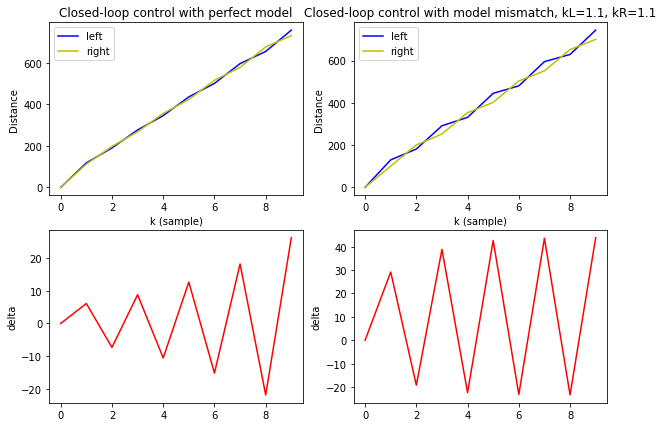

Steady state error = 0.00
Steady state error = 15.76
kL=0.5, kR=0.5
Eigenvalue of system: 1-kL-kR=0; chosen k values


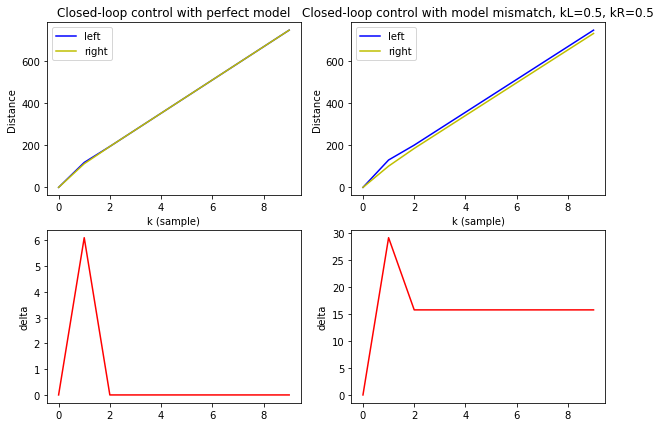

Steady state error = 0.00
Steady state error = 39.23
kL=0.2, kR=0.2
Eigenvalue of system: 1-kL-kR=0.6; stable


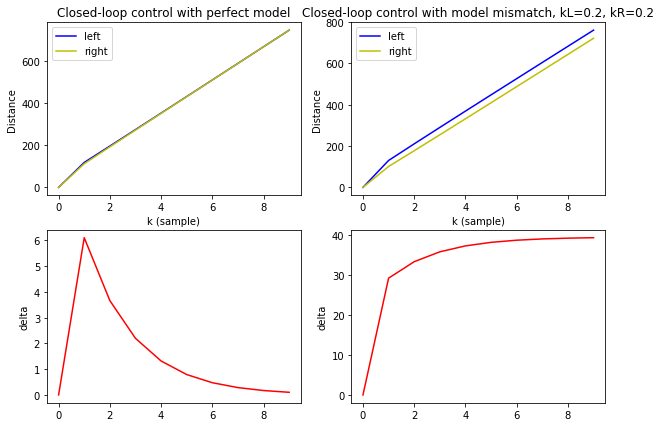

Steady state error = oscillatory
Steady state error = oscillatory
kL=1, kR=1
Eigenvalue of system: 1-kL-kR=-1; oscillatory, marginally stable


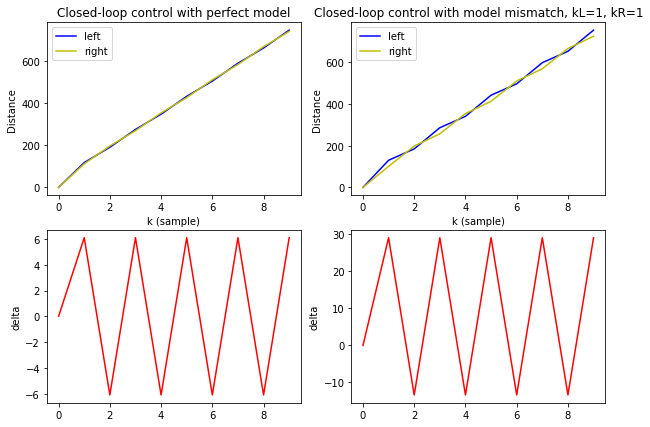

Steady state error = 6.10
Steady state error = unbounded
kL=-0.3, kR=0.3
Eigenvalue of system: 1-kL-kR=1; marginally stable


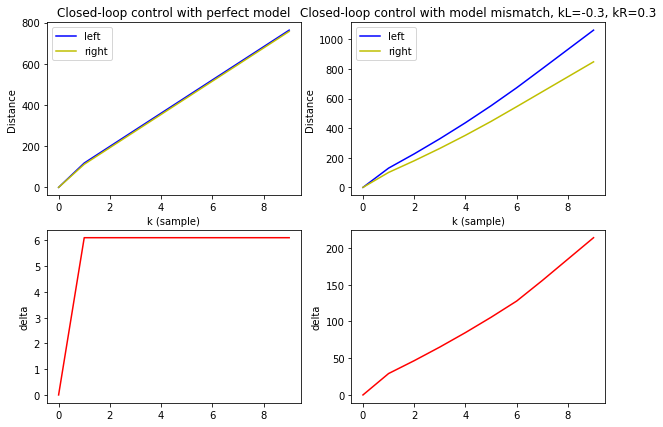

Steady state error = 0.00
Steady state error = 15.76
kL=0.5, kR=0.5
Eigenvalue of system: 1-kL-kR=0; stable, corrects error in one step


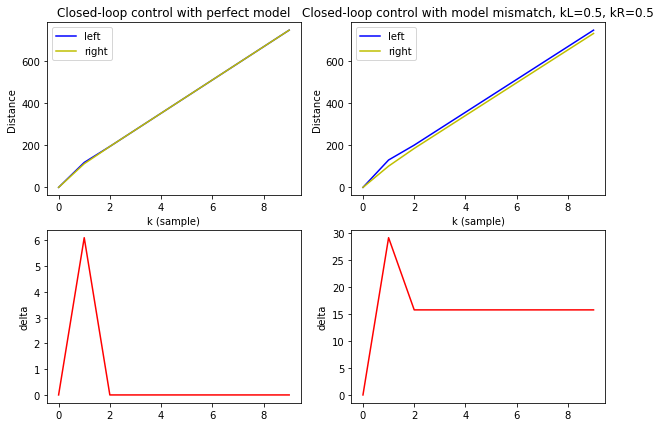

In [22]:
k_left, k_right = None, None
steady_state_error = None

# Maps description of k_values to (k_left, k_right)
k_values = {
    "marginally stable": (-0.3, 0.3),
    "stable, corrects error in one step": (0.5, 0.5),
    "oscillatory, marginally stable": (1, 1),
    "oscillatory, unstable": (1.1, 1.1),
    "stable": (0.2, 0.2),
    "chosen k values": (0.5, 0.5)  # TODO: record your chosen k-values here
}

for key in k_values:
    k_left, k_right = k_values[key]

    titles = ["Closed-loop control with perfect model",
              "Closed-loop control with model mismatch, kL={}, kR={}".format(k_left, k_right)]
    _, delta = utils.two_sims(titles, simulator, v_star, drive_straight_left_cl, drive_straight_right_cl)

    print("kL={}, kR={}".format(k_left, k_right))
    print("Eigenvalue of system: 1-kL-kR={:.2g}; {}".format(1-k_left-k_right, key))
    plt.show()
    steady_state_error = delta[-1]

<a id='part23'></a>
## Closed Loop Implementation

Now implement the controller on the Launchpad. The sketch **`closed_loop.ino`** contains some code that implements the closed loop control. 

- Fill out `CODE BLOCK CON1` with your control gains **`k_left`** and **`k_right`** as well as your theta, beta, and v_star values from System ID.
- Fill out `CODE BLOCK CON2` with your closed-loop control scheme.
- Fill out `CODE BLOCK CON0` in the body of the loop function to calculate the control inputs. Inspect this code to see how the control system is implemented. For now, ignore the term `delta_ss`, as it's currently set to 0.
- Upload the sketch to your LaunchPad.
    - Make sure that the car is suspended above the desk. Your car wheels are going to move in this step.
    - Check that the wheels are moving as you expect them to.
    - If you use your hand to put some friction on the wheels, does the feedback correct for it?

Once you are satisfied that your motors work and your closed-loop control is implemented, run the car on the ground. If it behaves erroneously (for example the controller oscillates), try different eigenvalues. Our simulations compare our possibly mismatched linear model with a linear approximation of our car. In reality, the car is a nonlinear system.

**Note:** It's possible that the car curves *slightly* over long distances, even if it the car thinks it's traveling straight. This can be due to factors such as mechanical differences past the shaft of the motor, including slight variation in wheel size or wheel wobble. We can fix this after we make the car turn.

<span style='color:red'>**What are some reasons why the simulation might behave differently from the car? What about the differences between when the car is on the ground versus when it is on the desk?**</span>

<a id='part24'></a>
## K-Value Tuning

How did the car behave? It probably didn't go perfectly straight with the first set of k values that you picked. In order to find the "right" k values, we will need to analyze the behavior of our car. Recall in lecture that we learned about how the control values will affect the convergence of a system.


![](https://upload.wikimedia.org/wikipedia/commons/c/c0/Change_with_Ki.png)

The above plot can be summarized as:
- if k is too small, it takes a long time to converge to our desired solution
- if k is too big, oscillations happen

We can use this information to help guide us to k values that get our car going straight. Check out this youtube playlist if you need some examples of what each case could look like: https://www.youtube.com/playlist?list=PLQ1OVCqw6RUPgCmv8H6y9qbcMBT8lotDt

You will likely have to try several sets of k values until you find one that works well with your particular car. If you find yourself having a lot of trouble narrowing in on some, ask your GSI for help!

<a id='part25'></a>

## Steady State Error Correction

Lastly, what if we want the car to travel in (approximately) the same direction as when it starts moving? We can manually add the known steady state error $\delta_{ss}$ to each calculation of the error $\delta$. Accounting for the known $\delta_{ss}$ helps the model better respond to unexpected pertubations affecting $\delta$ which increases the model's control strength.

We now calculate $\delta[k]=d_L - d_R + \delta_{ss}$.


Steady state error = 0.00


Text(0,0.5,'delta')

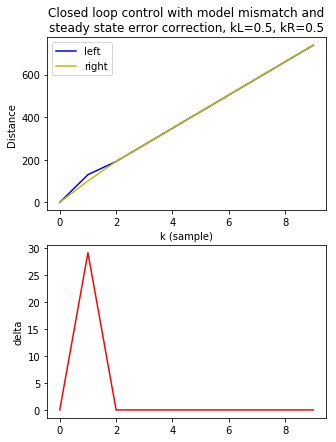

In [23]:
plt.figure(figsize=(5, 7))
plt.subplot(211)
# Simulate using steady_state_error
d = simulator.simulate(
    v_star, drive_straight_left_cl, drive_straight_right_cl, mismatch_error=0.1, offset=steady_state_error)
delta = simulator.plot(d)
plt.title("Closed loop control with model mismatch and\nsteady state error correction, kL={}, kR={}"
          .format(k_left, k_right))
plt.subplot(212)
plt.plot(delta, 'r')
plt.ylabel('delta')

- `closed_loop.ino` collects data as it runs, including $\delta[k]$.
    - Let the car run until it settles to (approximately) straight.
    - Switch off the motors and plug the MSP into your computer.
    - Close the serial monitor (if it's open), and reopen the serial monitor.
- Note the steady-state value $\delta_{ss}$.
    - The first column of the printed data is $\delta$ over time.
    - **If $\delta$ doesn't reach steady-state, the car is not going straight according to the sensors.**
        - It's okay if it isn't exactly constant.
        - Just be sure the variation is small in proportion to the average value.

## Implementing Steady State Error Correction

- Input your value of $\delta_{ss}$ in `CODE BLOCK CON3` in **`closed_loop.ino`**.
- Convince yourself that we need to *add* this value in `CODE BLOCK CON0`.

For example, if the car drives straight but turned right from its initial heading, we want the right wheel to farther so it turns back towards the left. Adding a positive number to delta accomplishes this.

<a id='part3'></a>

## Open-Loop Comparison

To compare your control scheme to an open-loop model, you can set both of your K-values to zero. Try running your car with K-values of zero. Does your car behave similarly? Does it go straight?

Why do you think you see the behavior you see?

<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">

## <span style="color:green">CHECKOFF</span>
 <span style="color:green">**Show your GSI that your car moves in a straight line.** Your GSI will also check your block diagram and k values.</span>